In [1]:
import pandas as pd
import sqlite3
import os
import requests
import json
import time
import datetime as dt
import pandas as pd

In [2]:
def drop_other_tables(db_path="sampling_frame.db", keep_table="sampled_collections"):
    """
    Drops all user-created tables in 'db_path' except for 'keep_table',
    ignoring any internal SQLite tables like 'sqlite_sequence'.
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Get all tables from the SQLite master, ignoring internal tables.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = [row[0] for row in cursor.fetchall()]

    for tbl in tables:
        # Skip the keep_table and any internal SQLite tables (e.g., sqlite_sequence).
        if tbl != keep_table and not tbl.startswith('sqlite_'):
            cursor.execute(f"DROP TABLE IF EXISTS '{tbl}'")
            print(f"Dropped table: {tbl}")

    conn.commit()
    conn.close()
    print(f"Retained only '{keep_table}' and any internal SQLite tables in {db_path}.")

def main():
    source_db = "sampling_frame.db"
    new_db = "cluster_performance.db"
    keep_table = "sampled_collections"
    csv_path = "clustered_6.xlsx"

    # 1) Drop other user-created tables except keep_table
    drop_other_tables(db_path=source_db, keep_table=keep_table)

    # 2) Read CSV with cluster labels
    df_csv = pd.read_excel(csv_path)
    print(f"Loaded {len(df_csv)} rows from '{csv_path}'.")

    # Expect columns: 'slug' and 'cluster_label'
    if "slug" not in df_csv.columns or "cluster_label" not in df_csv.columns:
        raise ValueError("CSV must contain 'slug' and 'cluster_label' columns.")

    # 3) Load 'sampled_collections' table from the source DB
    conn_source = sqlite3.connect(source_db)
    df_db = pd.read_sql_query(f"SELECT * FROM {keep_table}", conn_source)
    conn_source.close()
    print(f"Loaded {len(df_db)} rows from '{keep_table}' in '{source_db}'.")

    # 4) Merge 'cluster_label' on slug_name = slug
    if "slug_name" not in df_db.columns:
        raise ValueError(f"Table '{keep_table}' must have a 'slug_name' column for merging.")

    df_merged = pd.merge(
        df_db,
        df_csv[["slug", "cluster_label"]],
        how="left",
        left_on="slug_name",
        right_on="slug"
    )
    print(f"After merging, {df_merged['cluster_label'].notna().sum()} rows matched cluster labels.")

    # 5) Write merged data to a NEW DB: 'cluster_performance.db'
    conn_new = sqlite3.connect(new_db)
    df_merged.to_sql(keep_table, conn_new, if_exists="replace", index=False)
    conn_new.commit()
    conn_new.close()

    print(f"Merged data successfully written to '{new_db}' in table '{keep_table}'.")

if __name__ == "__main__":
    main()

Retained only 'sampled_collections' and any internal SQLite tables in sampling_frame.db.
Loaded 245 rows from 'clustered_6.xlsx'.
Loaded 245 rows from 'sampled_collections' in 'sampling_frame.db'.
After merging, 243 rows matched cluster labels.
Merged data successfully written to 'cluster_performance.db' in table 'sampled_collections'.


Metrics from Rarible

In [ ]:
def transform_collection_id(collection_id):
    """
    Example input: "0x14021c5...:base"
    Desired output: "BASE:0x14021c5..."
    """
    if not isinstance(collection_id, str) or ":" not in collection_id:
        return None

    address_part, chain_part = collection_id.split(":", 1)
    chain_upper = chain_part.upper()
    return f"{chain_upper}:{address_part}"

def fetch_rarible_stats(collection_str, period="ALL", api_key=""):
    """
    Calls Rarible stats endpoint for the given 'collection_str' (e.g. "BASE:0x...")
    period can be: ALL, D1, D7, D30, etc.
    """
    url = f"https://api.rarible.org/v2.0/data/collections/{collection_str}/statistics/period"
    headers = {
        "accept": "application/json",
        "X-API-KEY": api_key
    }
    params = {
        "period": period
    }
    try:
        resp = requests.get(url, headers=headers, params=params, timeout=10)
        resp.raise_for_status()
        return resp.json()
    except Exception as e:
        print(f"Error fetching stats for {collection_str}, period={period}: {e}")
        return None

def parse_rarible_response(data):

    if not data:
        return None

    period_val = data.get("period")
    volume_obj = data.get("volume", {})
    volume_value = volume_obj.get("value")
    volume_value_usd = volume_obj.get("valueUsd")
    floor_change_percent = data.get("floorChangePercent")

    return {
        "period": period_val,
        "volume_value": volume_value,
        "volume_value_usd": volume_value_usd,
        "floor_change_percent": floor_change_percent,
        "raw_json": json.dumps(data)
    }

def main():
    db_path = "cluster_performance.db"
    new_table = "rarible_stats"
    api_key = "your_key"  # Replace with valid key
    time_windows = ["ALL", "D30"]

    # 1) Load Rarible collections from cluster_performance.db
    conn = sqlite3.connect(db_path)
    df_rarible = pd.read_sql_query(
        "SELECT * FROM sampled_collections WHERE marketplace='Rarible'",
        conn
    )
    conn.close()

    print(f"Found {len(df_rarible)} Rarible collections to process.")

    stats_records = []

    for i, row in df_rarible.iterrows():
        col_id = row.get("collection_id", None)
        if not isinstance(col_id, str) or ":" not in col_id:
            print(f"Skipping row {i}: invalid or missing 'collection_id'.")
            continue

        rarible_input = transform_collection_id(col_id)
        if rarible_input is None:
            print(f"Skipping row {i}: transformation failed for {col_id}")
            continue

        # For each time window: "ALL", "D30"
        for tw in time_windows:
            data = fetch_rarible_stats(rarible_input, period=tw, api_key=api_key)
            time.sleep(1)  # Pause for 1 second after each call to reduce rate-limit hits

            if data is None:
                continue

            parsed = parse_rarible_response(data)
            if parsed is None:
                continue

            record = {
                "collection_id": col_id,
                "rarible_input": rarible_input,
                "time_window": tw,
                **parsed
            }
            stats_records.append(record)

    if not stats_records:
        print("No data retrieved or all calls failed.")
        return

    df_stats = pd.DataFrame(stats_records)

    # 3) Write results to rarible_stats table
    conn = sqlite3.connect(db_path)
    df_stats.to_sql(new_table, conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()

    print(f"Wrote {len(df_stats)} records to '{new_table}' in '{db_path}'.")

In [4]:
if __name__ == "__main__":
    main()

Found 99 Rarible collections to process.
Wrote 198 records to 'rarible_stats' in 'cluster_performance.db'.


Metrics from OpenSea

In [ ]:
def fetch_opensea_stats(slug, api_key):
    """
    Fetch stats for a given OpenSea slug, returning parsed data if successful.
    Includes both 'all time' data from 'total' and '30d' data from the 'intervals' array.
    """
    url = f"https://api.opensea.io/api/v2/collections/{slug}/stats"
    headers = {
        "accept": "application/json",
        "x-api-key": api_key
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching stats for slug '{slug}': {e}")
        return None

def parse_stats(data):
    """
    Extracts relevant fields from the OpenSea stats JSON, including:
      - All-time data (from 'total')
      - 30d data (from intervals, 'thirty_day')
    
    Returns a dict with the parsed fields, or None if incomplete.
    """
    if not data:
        return None

    total = data.get("total", {})
    intervals = data.get("intervals", [])

    # Extract all-time fields from "total"
    volume_alltime = total.get("volume")
    sales_alltime = total.get("sales")
    avg_price_alltime = total.get("average_price")
    num_owners = total.get("num_owners")
    market_cap = total.get("market_cap")
    floor_price = total.get("floor_price")
    floor_symbol = total.get("floor_price_symbol")

    # Identify the "thirty_day" interval from intervals
    volume_30d, sales_30d, avg_price_30d = (None, None, None)
    for interval_data in intervals:
        interval_name = interval_data.get("interval")
        if interval_name == "thirty_day":
            volume_30d = interval_data.get("volume")
            sales_30d = interval_data.get("sales")
            avg_price_30d = interval_data.get("average_price")
            break

    return {
        "volume_alltime": volume_alltime,
        "sales_alltime": sales_alltime,
        "avg_price_alltime": avg_price_alltime,
        "num_owners": num_owners,
        "market_cap": market_cap,
        "floor_price": floor_price,
        "floor_symbol": floor_symbol,
        "volume_30d": volume_30d,
        "sales_30d": sales_30d,
        "avg_price_30d": avg_price_30d,
        "raw_json": json.dumps(data)  # keep entire JSON for reference
    }

def main():
    db_path = "cluster_performance.db"
    api_key = "your_key"  # replace with your valid key

    # Connect to cluster_performance.db to load OpenSea collections
    conn = sqlite3.connect(db_path)
    df_opensea = pd.read_sql_query(
        "SELECT * FROM sampled_collections WHERE marketplace='OpenSea'",
        conn
    )
    conn.close()

    print(f"Found {len(df_opensea)} OpenSea collections to process.")

    stats_records = []

    for i, row in df_opensea.iterrows():
        slug = row.get("slug_name", None)
        if not isinstance(slug, str) or slug.strip() == "":
            print(f"Skipping row {i}: slug_name missing or invalid.")
            continue

        data = fetch_opensea_stats(slug, api_key)
        if data is None:
            continue

        parsed = parse_stats(data)
        if parsed is None:
            print(f"Skipping slug '{slug}': incomplete data.")
            continue

        record = {
            "slug_name": slug,
            **parsed  # merges the dict with fields like volume_alltime, volume_30d, etc.
        }
        stats_records.append(record)

    if not stats_records:
        print("No data retrieved or all calls failed.")
        return

    # Convert to DataFrame
    df_stats = pd.DataFrame(stats_records)

    # Write results into a new table 'opensea_stats'
    conn = sqlite3.connect(db_path)
    df_stats.to_sql("opensea_stats", conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()

    print(f"Wrote {len(df_stats)} records to 'opensea_stats' in '{db_path}'.")

if __name__ == "__main__":
    main()

Found 76 OpenSea collections to process.
Error fetching stats for slug 'robert-deniro-1': HTTPSConnectionPool(host='api.opensea.io', port=443): Read timed out. (read timeout=10)
Error fetching stats for slug 'farmine-lands': 400 Client Error: Bad Request for url: https://api.opensea.io/api/v2/collections/farmine-lands/stats
Wrote 74 records to 'opensea_stats' in 'cluster_performance.db'.


Metrics from MagicEden

In [6]:
def fetch_magic_eden_stats(symbol, time_window="all"):

    base_url = f"https://api-mainnet.magiceden.dev/v2/collections/{symbol}/stats"
    params = {
        "timeWindow": time_window
    }
    headers = {
        "accept": "application/json"
    }

    try:
        response = requests.get(base_url, headers=headers, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching stats for '{symbol}' with timeWindow={time_window}: {e}")
        return None

def main():
    db_path = "cluster_performance.db"  # Database with 'sampled_collections'
    new_table = "magiceden_stats"       # We'll store results here
    time_windows = ["all", "30d"]       # timeFrame calls we want

    # 1) Connect to cluster_performance.db, read all MagicEden rows
    conn = sqlite3.connect(db_path)
    df_magic = pd.read_sql_query(
        "SELECT * FROM sampled_collections WHERE marketplace='MagicEden'",
        conn
    )
    conn.close()

    print(f"Found {len(df_magic)} MagicEden collections to process.")

    records = []

    for i, row in df_magic.iterrows():
        slug = row.get("slug_name", None)
        if not isinstance(slug, str) or slug.strip() == "":
            print(f"Skipping row {i}: 'slug_name' missing or invalid.")
            continue

        # 2) Fetch stats for each time window
        for tw in time_windows:
            data = fetch_magic_eden_stats(slug, time_window=tw)
            if data is None:
                continue  # skip if error or no data

            symbol = data.get("symbol")  
            floor_price = data.get("floorPrice")  
            listed_count = data.get("listedCount")     
            volume_all = data.get("volumeAll")         

            # Add record
            record = {
                "slug_name": slug,
                "time_window": tw,
                "symbol": symbol,
                "floor_price": floor_price,
                "listed_count": listed_count,
                "volume": volume_all,  # for 30d calls, this is "volume30d" in practice
                "raw_json": json.dumps(data)
            }
            records.append(record)

    if not records:
        print("No data retrieved or all calls failed.")
        return

    # Convert to DataFrame
    df_stats = pd.DataFrame(records)

    # 3) Write results to 'magiceden_stats'
    conn = sqlite3.connect(db_path)
    df_stats.to_sql(new_table, conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()

    print(f"Wrote {len(df_stats)} records to '{new_table}' in '{db_path}'.")

if __name__ == "__main__":
    main()

Found 50 MagicEden collections to process.
Wrote 100 records to 'magiceden_stats' in 'cluster_performance.db'.


Metrics from Atomic

In [7]:
def fetch_atomic_stats(collection_name, symbol="WAX"):
    """
    Attempts to call the AtomicMarket stats endpoint:
    https://wax.api.atomicassets.io/atomicmarket/v1/stats/collections/{collection_name}?symbol={symbol}
    
    Returns the parsed JSON or None if an error occurs.
    """
    url = f"https://wax.api.atomicassets.io/atomicmarket/v1/stats/collections/{collection_name}"
    params = {"symbol": symbol}
    headers = {"accept": "application/json"}

    try:
        resp = requests.get(url, params=params, headers=headers, timeout=10)
        resp.raise_for_status()
        return resp.json()
    except Exception as e:
        print(f"Error fetching stats for '{collection_name}', symbol={symbol}: {e}")
        return None
    
def parse_atomic_response(data):
    
    if not data or not data.get("success", False):
        return None

    # Extract symbol details
    symbol_data = data.get("data", {}).get("symbol", {})
    token_contract = symbol_data.get("token_contract")
    token_symbol = symbol_data.get("token_symbol")
    token_precision = symbol_data.get("token_precision")

    # In your actual JSON, there's "result" (singular), not "results" (plural)
    result_obj = data.get("data", {}).get("result")
    if not isinstance(result_obj, dict):
        return None  # or skip if result_obj is None or not a dict

    contract = result_obj.get("contract")
    collection_name = result_obj.get("collection_name")
    listings = result_obj.get("listings")
    volume = result_obj.get("volume")
    sales = result_obj.get("sales")

    return {
        "token_contract": token_contract,
        "token_symbol": token_symbol,
        "token_precision": token_precision,
        "contract": contract,
        "collection_name": collection_name,
        "listings": listings,
        "volume": volume,
        "sales": sales,
        "raw_json": json.dumps(data)
    }

def main():
    db_path = "cluster_performance.db"
    new_table = "atomic_stats"
    symbol_to_use = "WAX"  

    # 1) Load 'Atomic' collections from the DB
    conn = sqlite3.connect(db_path)
    df_atomic = pd.read_sql_query(
        "SELECT * FROM sampled_collections WHERE marketplace='Atomic'",
        conn
    )
    conn.close()

    print(f"Found {len(df_atomic)} 'Atomic' collections to process.")

    records = []

    for i, row in df_atomic.iterrows():
        slug = row.get("slug_name", None)
        if not isinstance(slug, str) or slug.strip() == "":
            print(f"Skipping row {i}: 'slug_name' invalid or missing.")
            continue

        # 2) Fetch data from Atomic
        try:
            data = fetch_atomic_stats(slug, symbol="WAX")

            print("Raw response:", data)

        except requests.HTTPError as he:
            print(f"HTTPError for slug {slug}: {he.response.status_code}")

        time.sleep(1)  # Wait 1s to reduce chance of rate-limit

        if data is None:
            continue

        parsed = parse_atomic_response(data)
        if parsed is None:
            continue

        # Add slug_name for reference
        record = {
            "slug_name": slug,
            "symbol_used": symbol_to_use,
            **parsed
        }
        records.append(record)

    if not records:
        print("No data retrieved or all calls failed.")
        return

    # Convert to DataFrame
    df_stats = pd.DataFrame(records)

    # 3) Write results to 'atomic_stats' table
    conn = sqlite3.connect(db_path)
    df_stats.to_sql(new_table, conn, if_exists="replace", index=False)
    conn.commit()
    conn.close()

    print(f"Wrote {len(df_stats)} records to '{new_table}' in '{db_path}'.")


In [8]:
if __name__ == "__main__":
    main()

Found 20 'Atomic' collections to process.
Raw response: {'success': True, 'data': {'symbol': {'token_symbol': 'WAX', 'token_contract': 'eosio.token', 'token_precision': 8}, 'result': {'contract': 'atomicassets', 'collection_name': 'dimebagswaxd', 'volume': '0', 'sales': '0', 'name': 'dimebags', 'img': 'QmQgF39hSxL72Wto1DhgnTXKwM3PWGNgJWo7FvoCWzqA6o', 'author': 'wilsonfiskwx', 'allow_notify': True, 'authorized_accounts': ['wilsonfiskwx'], 'notify_accounts': [], 'market_fee': 0.13, 'data': {'img': 'QmQgF39hSxL72Wto1DhgnTXKwM3PWGNgJWo7FvoCWzqA6o', 'name': 'dimebags', 'description': "Catch em' on the Corner!\nSell em at mark-up!"}, 'created_at_time': '1620168533000', 'created_at_block': '117454669'}}, 'query_time': 1745148787590}
Raw response: {'success': True, 'data': {'symbol': {'token_symbol': 'WAX', 'token_contract': 'eosio.token', 'token_precision': 8}, 'result': {'contract': 'atomicassets', 'collection_name': 'alienwor1dsz', 'volume': '0', 'sales': '0', 'name': 'Tree Forest on Neri',

Analysis by Cluster

In [9]:
DB_PATH = "cluster_performance.db"

def read_query(conn, query):
    """Helper to wrap pd.read_sql_query."""
    return pd.read_sql_query(query, conn)

def main():
    conn = sqlite3.connect(DB_PATH)

    # ------------------------------------------------------------------ #
    # 1.  Base table: collection ↔ cluster ↔ marketplace
    # ------------------------------------------------------------------ #
    df_col = read_query(
        conn,
        """
        SELECT slug_name, collection_id, marketplace, cluster_label
        FROM sampled_collections
        """
    )

    # ------------------------------------------------------------------ #
    # 2.  Per‑marketplace stats tables  ➜  (slug_name, volume)
    # ------------------------------------------------------------------ #

    # 2a. OpenSea
    df_os = read_query(
        conn,
        """
        SELECT slug_name,
               volume_alltime AS volume
        FROM opensea_stats
        """
    ).assign(marketplace="OpenSea")

    # 2b. MagicEden  – keep only time_window='all'
    df_me = read_query(
        conn,
        """
        SELECT slug_name,
               volume,
               time_window
        FROM magiceden_stats
        WHERE time_window = 'all'
        """
    ).drop(columns="time_window").assign(marketplace="MagicEden")

    # 2c. Atomic
    df_at = read_query(
        conn,
        """
        SELECT slug_name,
               volume
        FROM atomic_stats
        """
    ).assign(marketplace="Atomic")

    # 2d. Rarible  – join on *collection_id* rather than slug_name
    df_ra = read_query(
        conn,
        """
        SELECT collection_id,
               volume_value   AS volume,
               period
        FROM rarible_stats
        WHERE period = 'ALL'
        """
    ).drop(columns="period").assign(marketplace="Rarible")

    # ------------------------------------------------------------------ #
    # 3.  Merge stats back to sampled_collections
    #     · OpenSea / MagicEden / Atomic   ➜ join on slug_name
    #     · Rarible                        ➜ join on collection_id
    # ------------------------------------------------------------------ #
    df_merge_slug = pd.concat([df_os, df_me, df_at], ignore_index=True)

    merged_slug = df_col.merge(
        df_merge_slug,
        on=["slug_name", "marketplace"],
        how="left"
    )

    merged_rarible = df_col.merge(
        df_ra,
        on=["collection_id", "marketplace"],
        how="left"
    )

    # Bring everything together
    df_all = pd.concat([merged_slug, merged_rarible], ignore_index=True)

    # Volume column is string in some tables → convert to numeric (coerce errors)
    df_all["volume"] = pd.to_numeric(df_all["volume"], errors="coerce")

    # ------------------------------------------------------------------ #
    # 4.  Aggregate statistics
    # ------------------------------------------------------------------ #
    # 4a.  Per‑cluster summary (across marketplaces; beware unit mix!)
    cluster_summary = (
        df_all
        .groupby("cluster_label")["volume"]
        .agg(
            count  = "count",
            mean   = "mean",
            median = "median",
            min    = "min",
            max    = "max",
            std    = "std"
        )
        .reset_index()
    )

    # 4b.  Optional: per‑cluster *and* marketplace
    cluster_mkt_summary = (
        df_all
        .groupby(["cluster_label", "marketplace"])["volume"]
        .agg(
            count  = "count",
            mean   = "mean",
            median = "median"
        )
        .reset_index()
        .sort_values(["cluster_label", "marketplace"])
    )

    conn.close()

    # ------------------------------------------------------------------ #
    # 5.  Display or export
    # ------------------------------------------------------------------ #
    print("=== Cluster‑level statistics (raw native units) ===")
    print(cluster_summary.to_string(index=False, float_format="{:,.2f}".format))

    print("\n=== Cluster × Marketplace statistics (optional) ===")
    print(cluster_mkt_summary.to_string(index=False, float_format="{:,.2f}".format))

In [10]:
if __name__ == "__main__":
    main()

=== Cluster‑level statistics (raw native units) ===
 cluster_label  count                 mean            median  min                    max                   std
          0.00    128                42.09              0.00 0.00               5,387.06                476.15
          1.00     14                49.47              0.00 0.00                 691.67                184.84
          2.00     41 7,927,898,293,182.72 76,518,000,000.00 0.00 191,484,511,013,033.00 30,960,191,540,285.14
          3.00     31 2,095,622,039,883.13              0.00 0.00  64,780,279,118,337.00 11,633,806,702,855.22
          4.00     23         8,695,652.17              0.00 0.00         200,000,000.00         41,702,882.81

=== Cluster × Marketplace statistics (optional) ===
 cluster_label marketplace  count                  mean                median
          0.00     OpenSea     45                119.71                  0.00
          0.00     Rarible     83                  0.00                  

NFTs from OpenSea

In [ ]:
DB     = "cluster_performance.db"
APIKEY = "your_key"
HDRS   = {"accept": "application/json", "x-api-key": APIKEY}

DDL = """
CREATE TABLE IF NOT EXISTS nft_transactions (
    tx_hash        TEXT PRIMARY KEY,
    nft_id         TEXT,
    collection_slug TEXT,
    marketplace    TEXT,
    block_time     TEXT,
    price_native   REAL,
    price_usd      REAL,
    buyer          TEXT,
    seller         TEXT,
    raw_json       TEXT,
    fetched_at     TEXT
);
"""

def ensure_column(con):
    cols = [c[1] for c in con.execute("PRAGMA table_info(nft_transactions);")]
    if "collection_slug" not in cols:
        con.execute("ALTER TABLE nft_transactions ADD COLUMN collection_slug TEXT;")
        con.commit()

def utc_now() -> str:
    return dt.datetime.utcnow().isoformat(timespec="seconds")

# ---------------------------------------------------------------------------
def fetch_collection_sales(slug: str, delay=0.35):
    base = f"https://api.opensea.io/api/v2/events/collection/{slug}"
    cursor = None
    while True:
        params = {"event_type": "sale", "limit": 50}
        if cursor:
            params["next"] = cursor
        r = requests.get(base, params=params, headers=HDRS, timeout=15)
        if r.status_code == 404:
            return
        r.raise_for_status()
        js = r.json()

        for ev in js.get("asset_events", []):
            if ev.get("event_type") == "sale":
                yield ev

        cursor = js.get("next")
        if not cursor:
            break
        time.sleep(delay)

# ---------------------------------------------------------------------------
def main():
    con = sqlite3.connect(DB)
    con.execute(DDL)
    ensure_column(con)

    slugs = pd.read_sql_query(
        "SELECT slug_name FROM sampled_collections WHERE marketplace='OpenSea';",
        con
    )["slug_name"].tolist()

    total = 0
    for slug in slugs:
        print(f"Fetching sales for {slug} …")
        batch = []

        for ev in fetch_collection_sales(slug):
            nft  = ev.get("nft", {})
            contract = nft.get("contract")
            tok_id   = nft.get("identifier")
            if not (contract and tok_id):
                continue

            nft_id = f"{contract}:{tok_id}"

            pay = ev.get("payment") or {}
            qty = int(pay.get("quantity", 0) or 0)
            dec = pay.get("decimals", 0) or 0
            price_native = qty / (10 ** dec) if qty else None

            batch.append((
                ev.get("transaction") or ev.get("order_hash"),
                nft_id,
                slug,
                "OpenSea",
                ev.get("event_timestamp"),
                price_native,
                None,                        # USD price not supplied
                ev.get("buyer"),
                ev.get("seller"),
                json.dumps(ev),
                utc_now()
            ))

        if batch:
            con.executemany(
                """INSERT OR IGNORE INTO nft_transactions
                   (tx_hash, nft_id, collection_slug, marketplace, block_time,
                    price_native, price_usd, buyer, seller, raw_json, fetched_at)
                   VALUES (?,?,?,?,?,?,?,?,?,?,?);""",
                batch
            )
            con.commit()
            print(f"  ↳ {len(batch)} sales written.")
            total += len(batch)
        else:
            print("  ↳ no sales.")

    con.close()
    print(f"Done – {total} OpenSea sales inserted.")

In [14]:
if __name__ == "__main__":
    main()

Fetching sales for zora-posts-19156 …
  ↳ no sales.
Fetching sales for titanshade …
  ↳ no sales.
Fetching sales for summer-vibe-10 …
  ↳ no sales.
Fetching sales for stained-glasswindows …
  ↳ no sales.
Fetching sales for shib-chadmoney …
  ↳ no sales.
Fetching sales for me-physical-collectibles-10 …
  ↳ no sales.
Fetching sales for lens-collect-profile-199929-publication-3 …
  ↳ no sales.
Fetching sales for hell-angels …
  ↳ 291 sales written.
Fetching sales for glow-panda-genesis …
  ↳ no sales.
Fetching sales for giants-g-nine-2024-emblem …
  ↳ no sales.
Fetching sales for dump-pepe-5 …
  ↳ no sales.
Fetching sales for delfin-ohno-blast …
  ↳ no sales.
Fetching sales for chumpzgoded-season-one …
  ↳ no sales.
Fetching sales for bbbdf-e …
  ↳ no sales.
Fetching sales for zora-posts-21385 …
  ↳ no sales.
Fetching sales for municipios-del-futuro-cluster-de-iot-de-la-comunid …
  ↳ no sales.
Fetching sales for mekaapes-blast …
  ↳ 47 sales written.
Fetching sales for dude-lottery …
  ↳ 

HTTPError: 400 Client Error: Bad Request for url: https://api.opensea.io/api/v2/events/collection/farmine-lands?event_type=sale&limit=50

In [15]:
def utc_now() -> str:
    return dt.datetime.utcnow().isoformat(timespec="seconds")

def ensure_tx_table(con: sqlite3.Connection):
    """Create table and add collection_slug if still missing."""
    con.execute("""
      CREATE TABLE IF NOT EXISTS nft_transactions (
        tx_hash         TEXT PRIMARY KEY,
        nft_id          TEXT,
        collection_slug TEXT,
        marketplace     TEXT,
        block_time      TEXT,
        price_native    REAL,
        price_usd       REAL,
        buyer           TEXT,
        seller          TEXT,
        raw_json        TEXT,
        fetched_at      TEXT
      );
    """)
    cols = [c[1] for c in con.execute("PRAGMA table_info(nft_transactions);")]
    if "collection_slug" not in cols:
        con.execute("ALTER TABLE nft_transactions ADD COLUMN collection_slug TEXT;")
        con.commit()

def fetch_collection_sales(slug: str, delay=0.35):
    """Yield each SALE event for one OpenSea collection slug."""
    base = f"https://api.opensea.io/api/v2/events/collection/{slug}"
    cursor = None
    while True:
        params = {"event_type": "sale", "limit": 50}
        if cursor:
            params["next"] = cursor
        r = requests.get(base, headers=HDRS, params=params, timeout=15)
        if r.status_code == 404:          # collection not found / delisted
            return
        r.raise_for_status()
        js = r.json()

        for ev in js.get("asset_events", []):
            if ev.get("event_type") == "sale":
                yield ev

        cursor = js.get("next")
        if not cursor:
            break
        time.sleep(delay)                 # keep well below 4 req/s

# ───────────────────── manual top‑up  ─────────────────────
def topup_missing_collections():
    missing_slugs = [
        "wrong-badge-rewards",
        "flora-fauna-frames",
        "alpha-mystic-collection",
        "my-world-73",
    ]

    con = sqlite3.connect(DB)
    ensure_tx_table(con)

    total_new = 0
    for slug in missing_slugs:
        print(f"Fetching sales for '{slug}' …")
        new_rows = 0

        try:
            for ev in fetch_collection_sales(slug):
                nft  = ev.get("nft", {}) or {}
                contract = nft.get("contract")
                token_id = nft.get("identifier")
                if not (contract and token_id):
                    continue

                nft_id = f"{contract}:{token_id}"

                pay = ev.get("payment") or {}
                qty = int(pay.get("quantity") or 0)
                dec = pay.get("decimals") or 0
                price_native = qty / (10 ** dec) if qty else None

                con.execute("""
                  INSERT OR IGNORE INTO nft_transactions
                    (tx_hash, nft_id, collection_slug, marketplace, block_time,
                     price_native, price_usd, buyer, seller, raw_json, fetched_at)
                  VALUES (?,?,?,?,?,?,?,?,?,?,?);
                """, (
                    ev.get("transaction") or ev.get("order_hash"),
                    nft_id,
                    slug,                       # ← collection reference
                    "OpenSea",
                    ev.get("event_timestamp"),
                    price_native,
                    None,                       # USD price not supplied
                    ev.get("buyer"),
                    ev.get("seller"),
                    json.dumps(ev),
                    utc_now()
                ))
                new_rows += con.total_changes

            con.commit()
            print(f"   ↳ {new_rows} new sales written.\n")
            total_new += new_rows

        except Exception as exc:
            print(f"Error while processing '{slug}': {exc}\n")

    con.close()
    print(f"Finished – added {total_new} additional OpenSea sales.")

In [16]:
if __name__ == "__main__":
    topup_missing_collections()

Fetching sales for 'wrong-badge-rewards' …
   ↳ 0 new sales written.

Fetching sales for 'flora-fauna-frames' …
   ↳ 0 new sales written.

Fetching sales for 'alpha-mystic-collection' …
   ↳ 0 new sales written.

Fetching sales for 'my-world-73' …
   ↳ 0 new sales written.

Finished – added 0 additional OpenSea sales.


Rarible 

In [ ]:
DB      = "cluster_performance.db"
RAR_KEY = "your_key"        
RAR_HEADERS = {"accept": "application/json", "X-API-KEY": RAR_KEY}


DDL_TX = """
CREATE TABLE IF NOT EXISTS nft_transactions (
    tx_hash        TEXT PRIMARY KEY,
    nft_id         TEXT,
    collection_slug TEXT,            -- NEW
    marketplace    TEXT,
    block_time     TEXT,
    price_native   REAL,
    price_usd      REAL,
    buyer          TEXT,
    seller         TEXT,
    raw_json       TEXT,
    fetched_at     TEXT,
    FOREIGN KEY (nft_id) REFERENCES nfts(nft_id)
);
"""

def ensure_slug_column(con):
    cols = [c[1] for c in con.execute("PRAGMA table_info(nft_transactions);")]
    if "collection_slug" not in cols:
        con.execute("ALTER TABLE nft_transactions ADD COLUMN collection_slug TEXT;")
        con.commit()

def utc():  
    return dt.datetime.utcnow().isoformat(timespec="seconds")

# ─────────────────────────────────────────────────────────────────────────────
def iter_rarible_sales(collection_id, page_size=100, pause=0.35):
    """
    Stream SELL activities for a collection such as 'BASE:0xabc…'.
    """
    url    = "https://api.rarible.org/v0.1/activities/byCollection"
    params = {"type": "SELL", "collection": collection_id, "size": page_size}

    while True:
        r = requests.get(url, headers=RAR_HEADERS, params=params, timeout=15)

        if r.status_code in (429, 403):           # rate‑limit
            print("   ↳ 429/403 – sleeping 1.5 s …")
            time.sleep(1.5)
            continue
        if r.status_code in (400, 404):           # bad / unknown collection
            return
        r.raise_for_status()

        js   = r.json()
        acts = js.get("activities", [])
        for act in acts:
            yield act

        nxt = js.get("cursor") or js.get("continuation")
        if not nxt:
            break
        params["cursor"] = nxt
        time.sleep(pause)

# ─────────────────────────────────────────────────────────────────────────────
def save_rarible_sales():
    con = sqlite3.connect(DB)
    con.execute(DDL_TX)
    ensure_slug_column(con)                      # make sure extra column exists

    df = pd.read_sql_query(
        """SELECT slug_name, collection_id
           FROM   sampled_collections
           WHERE  marketplace='Rarible';""",
        con
    )

    total = 0
    for slug, raw in df.itertuples(index=False):
        if ":" not in raw:
            continue
        addr, chain_suffix = raw.split(":", 1)
        coll_api_id = f"{chain_suffix.upper()}:{addr}"

        print(f"Fetching {slug}  ({coll_api_id}) …")

        inserted = 0
        for ev in iter_rarible_sales(coll_api_id):
            pay           = ev.get("payment") or {}
            price_native  = float(pay.get("value") or ev.get("price") or 0) or None
            price_usd     = float(ev.get("priceUsd") or ev.get("amountUsd") or 0) or None

            con.execute(
                """
                INSERT OR IGNORE INTO nft_transactions
                (tx_hash, nft_id, collection_slug, marketplace, block_time,
                 price_native, price_usd, buyer, seller, raw_json, fetched_at)
                VALUES (?,?,?,?,?,?,?,?,?,?,?);
                """,
                (
                    ev.get("transactionHash") or ev.get("id"),
                    None,
                    slug,                   # ← store slug here
                    "Rarible",
                    ev.get("date"),
                    price_native,
                    price_usd,
                    ev.get("buyer"),
                    ev.get("seller"),
                    json.dumps(ev),
                    utc()
                )
            )
            inserted += con.total_changes

        # optional stub if nothing was inserted
        if inserted == 0:
            con.execute(
                """INSERT OR IGNORE INTO nft_transactions
                   (tx_hash, collection_slug, marketplace, raw_json, fetched_at)
                   VALUES (?, ?, 'Rarible', ?, ?);""",
                (f"NO_SALES_{slug}", slug,
                 json.dumps({"note": "no SELL activities"}), utc())
            )

        con.commit()
        print(f"   ↳ {inserted} sales inserted.")
        total += inserted
        time.sleep(0.3)

    con.close()
    print(f"Done – {total} Rarible sales written.")

In [18]:
if __name__ == "__main__":
    save_rarible_sales()

Fetching d168  (ZKSYNC:0xb2ffa6075e0594cd62a2035381466cbf2f022274) …
   ↳ 0 sales inserted.
Fetching Szeged - Member  (BASE:0x8009c4e95f80cbf59127edafdeaa20eb7abf3563) …
   ↳ 0 sales inserted.
Fetching Pi-Verse  (ETHERLINK:0x482f1759dd48df2672c0b9a5fc6791b19f4fb7d3) …
   ↳ 18 sales inserted.
Fetching Miner Drop Weapon  (MATCH:0x358f263b33c338719f4fa98ecc807a82228a902f) …
   ↳ 0 sales inserted.
Fetching LayerZero Airdrop #16562  (APTOS:0xc219d80cac121b59c232041f72819d21e12e223ce8c543a7609a177b6fd16a0f) …
   ↳ 0 sales inserted.
Fetching Happy Chinese New Year  (MATCH:0x716ad1b6222046289c1664825cd9e4caf6253aec) …
   ↳ 0 sales inserted.
Fetching Base of Ape  (BASE:0x1d3fb02ec926043c39f7b4b0bade786f36472471) …
   ↳ 0 sales inserted.
Fetching xiandandan  (BASE:0x55b1316d3065f4f88733d0aed9632a5ab8906ebd) …
   ↳ 0 sales inserted.
Fetching meme #109  (ARBITRUM:0x77fef3c4c258da9d2a6ce739fa5436825ec28bb4) …
   ↳ 0 sales inserted.
Fetching Zora Posts  (BASE:0x14021c550e81fccc20a3b37fceab9b5461dde9

Atomic

In [19]:
DB          = "cluster_performance.db"
ATOMIC_URL  = "https://wax.api.atomicassets.io/atomicmarket/v1/prices/sales"
WAX_SYMBOL  = "WAX"                 # Atomic sales are denominated in WAX
REQ_DELAY   = 0.35                  # ~3 req/s is safe for the public endpoint

DDL = """
CREATE TABLE IF NOT EXISTS nft_transactions (
  tx_hash         TEXT PRIMARY KEY,
  nft_id          TEXT,
  collection_slug TEXT,
  marketplace     TEXT,
  block_time      TEXT,
  price_native    REAL,
  price_usd       REAL,
  buyer           TEXT,
  seller          TEXT,
  raw_json        TEXT,
  fetched_at      TEXT
);
"""

def ensure_column(con):
    """Make sure nft_transactions has the new collection_slug field."""
    cols = [c[1] for c in con.execute("PRAGMA table_info(nft_transactions);")]
    if "collection_slug" not in cols:
        con.execute("ALTER TABLE nft_transactions ADD COLUMN collection_slug TEXT;")
        con.commit()

def utc() -> str:
    return dt.datetime.utcnow().isoformat(timespec="seconds")

# ──────────────────────────────────────────────────────────────────────────
def iter_atomic_sales(collection, page_size=100, max_pages=500):
    """Yield every sale row for one Atomic collection."""
    page = 1
    while page <= max_pages:
        params = {
            "collection_name": collection,
            "symbol": WAX_SYMBOL,
            "page": page,
            "limit": page_size,
            "order": "desc"
        }
        r = requests.get(ATOMIC_URL, params=params, timeout=12)

        # very simple rate‑limit guard
        if r.status_code in (429, 503):
            print("      ↳ rate‑limit / busy, sleeping 2 s")
            time.sleep(2)
            continue

        if r.status_code == 404:
            return                      # unknown collection
        r.raise_for_status()

        rows = r.json().get("data", [])
        if not rows:
            return

        for row in rows:
            yield row
        page += 1
        time.sleep(REQ_DELAY)

# ──────────────────────────────────────────────────────────────────────────
def save_atomic_sales():
    con = sqlite3.connect(DB)
    con.execute(DDL)
    ensure_column(con)

    df = pd.read_sql(
        "SELECT slug_name FROM sampled_collections WHERE marketplace='Atomic';",
        con
    )

    grand_total = 0
    for (slug,) in df.itertuples(index=False):
        print(f"Collection '{slug}' …")
        inserted = 0

        try:
            for ev in iter_atomic_sales(slug):
                sale_id  = ev["sale_id"]
                nat_val  = float(ev["price"]) / (10 ** ev["token_precision"])

                con.execute("""
                    INSERT OR IGNORE INTO nft_transactions
                    (tx_hash, nft_id, collection_slug, marketplace, block_time,
                     price_native, price_usd, buyer, seller, raw_json, fetched_at)
                    VALUES (?,?,?,?,?,?,?,?,?,?,?);
                """, (
                    f"ATOMIC_{sale_id}",
                    None,                 # no per‑item id available from endpoint
                    slug,                 # ← stores collection reference
                    "Atomic",
                    ev["block_time"],
                    nat_val,
                    None,                 # no USD conversion yet
                    None,
                    None,
                    json.dumps(ev),
                    utc()
                ))
                inserted += con.total_changes

        except Exception as exc:
            print("   ↳ error:", exc)

        con.commit()
        print(f"   ↳ {inserted} sales saved.\n")
        grand_total += inserted

    con.close()
    print(f"FINISHED – {grand_total} Atomic sales written to nft_transactions")

In [20]:
if __name__ == "__main__":
    save_atomic_sales()

Collection 'dimebagswaxd' …
   ↳ 0 sales saved.

Collection 'alienwor1dsz' …
   ↳ 0 sales saved.

Collection 'watercolorzz' …
   ↳ 0 sales saved.

Collection 'adidasshoes3' …
   ↳ 0 sales saved.

Collection 'varialandsio' …
   ↳ 124875250 sales saved.

Collection 'waxwalletsto' …
   ↳ 0 sales saved.

Collection 'ycjhajx5bcol' …
   ↳ 0 sales saved.

Collection 'vikez1modern' …
   ↳ 0 sales saved.

Collection 'nftartdesing' …
   ↳ 0 sales saved.

Collection 'bestpepeever' …
   ↳ 0 sales saved.

Collection 'agoratest123' …
   ↳ 0 sales saved.

Collection 'oddsandendss' …
   ↳ 0 sales saved.

Collection 'agruneforyou' …
   ↳ 0 sales saved.

Collection '1a2b3c4d5e11' …
   ↳ 501999 sales saved.

Collection 'targetedby11' …
   ↳ 0 sales saved.

Collection 'ondjlfgjbuzp' …
   ↳ 0 sales saved.

Collection 'dreamhunters' …
   ↳ 0 sales saved.

Collection 'cardinallind' …
   ↳ 0 sales saved.

Collection 'bigcolection' …
   ↳ 0 sales saved.

Collection 'articulated1' …
   ↳ 0 sales saved.

FINISHE

Unify Data

In [24]:
# MagicEdeen

DB = "cluster_performance.db"
TABLE = "magiceden_stats"

# ──────────────────────────────────────────────────────────
def get_sol_usd() -> float:
    """Fetch the latest SOL⇄USD price (CoinGecko public endpoint)."""
    url = "https://api.coingecko.com/api/v3/simple/price"
    r = requests.get(url, params={"ids": "solana", "vs_currencies": "usd"}, timeout=10)
    r.raise_for_status()
    return float(r.json()["solana"]["usd"])

# ──────────────────────────────────────────────────────────
def main():
    sol_usd = get_sol_usd()
    print(f"Current SOL/USD ≈ {sol_usd:,.3f}")

    con = sqlite3.connect(DB)
    cur = con.cursor()

    # add columns only if they are missing
    cur.execute(f"PRAGMA table_info({TABLE})")
    cols = [c[1] for c in cur.fetchall()]
    if "floor_price_usd" not in cols:
        cur.execute(f"ALTER TABLE {TABLE} ADD COLUMN floor_price_usd REAL")
    if "volume_usd" not in cols:
        cur.execute(f"ALTER TABLE {TABLE} ADD COLUMN volume_usd REAL")

    # 1 lamport = 10‑9 SOL
    cur.execute(f"""
        UPDATE {TABLE}
        SET floor_price_usd = (floor_price / 1e9) * ?,
            volume_usd      = (volume     / 1e9) * ?
        WHERE floor_price IS NOT NULL
           OR volume     IS NOT NULL
    """, (sol_usd, sol_usd))

    con.commit()
    print(f"Updated {cur.rowcount} rows in '{TABLE}'.")
    con.close()

if __name__ == "__main__":
    main()

Current SOL/USD ≈ 137.080
Updated 97 rows in 'magiceden_stats'.


In [25]:
# Atomic
DB         = "cluster_performance.db"
TABLE_Tx   = "nft_transactions"
CG_ID_WAX  = "wax"           # CoinGecko ID for WAX (a.k.a. WAXP)

def get_wax_usd() -> float:
    url  = "https://api.coingecko.com/api/v3/simple/price"
    resp = requests.get(url,
                        params={"ids": CG_ID_WAX, "vs_currencies": "usd"},
                        timeout=10)
    resp.raise_for_status()
    return float(resp.json()[CG_ID_WAX]["usd"])

def main():
    wax_usd = get_wax_usd()
    print(f"Current WAX/USD ≈ {wax_usd:,.4f}")

    con = sqlite3.connect(DB)
    cur = con.cursor()

    cur.execute(f"""
        UPDATE {TABLE_Tx}
        SET    price_usd = price_native * ?
        WHERE  marketplace = 'Atomic'
          AND  price_native IS NOT NULL
    """, (wax_usd,))

    con.commit()
    print(f"Updated {cur.rowcount} Atomic transactions with USD prices.")
    con.close()

if __name__ == "__main__":
    main()

Current WAX/USD ≈ 0.0239
Updated 502 Atomic transactions with USD prices.


In [ ]:
# OpenSea

DB  = "cluster_performance.db"
TXT = "nft_transactions"

# --------------------------------------------------------------------------- #
CHAIN2SYMBOL = {
    "ethereum":        "eth",
    "matic":           "matic",
    "base":            "eth",
    "optimism":        "eth",
    "arbitrum_nova":   "eth",
    "blast":           "eth",
    "zora":            "eth",
    "bera_chain":      "bera",      # CoinGecko id may differ!
    "ronin":           "ron",
    "avalanche":       "avax",
    "klaytn":          "klay",
    "flow":            "flow",
    "ape_chain":       "ape",
    "sei":             "sei",
}

CG_ID = {                 # map symbol → Coingecko id
    "eth":"ethereum","matic":"matic-network","avax":"avalanche-2",
    "klay":"klay-token","flow":"flow","ron":"ronin",
    "ape":"apecoin","sei":"sei-network","bera":"berachain"
}

def get_prices(symbols):
    """Return dict {symbol: usd_price} from CoinGecko"""
    ids = ",".join({CG_ID[s] for s in symbols if s in CG_ID})
    url = "https://api.coingecko.com/api/v3/simple/price"
    r   = requests.get(url, params={"ids": ids, "vs_currencies": "usd"}, timeout=15)
    r.raise_for_status()
    data = r.json()
    return {sym: float(data[CG_ID[sym]]["usd"]) for sym in symbols if sym in CG_ID}

def utc(): return dt.datetime.utcnow().isoformat(timespec="seconds")

# --------------------------------------------------------------------------- #
def main():
    con = sqlite3.connect(DB)
    cur = con.cursor()

    # pull every OpenSea tx without USD price
    cur.execute(f"""
        SELECT rowid, raw_json, price_native
        FROM   {TXT}
        WHERE  marketplace='OpenSea' AND price_usd IS NULL
              AND price_native IS NOT NULL
    """)
    rows = cur.fetchall()

    # collect required symbols
    needed = set()
    parsed = []
    for rid, raw, native in rows:
        js = json.loads(raw)
        chain   = js.get("chain") or "ethereum"
        symbol  = CHAIN2SYMBOL.get(chain.lower())
        # fall back to payment.symbol if present
        pay_sym = (js.get("payment") or {}).get("symbol")
        if pay_sym and pay_sym.lower() in CG_ID:
            symbol = pay_sym.lower()
        if symbol:
            needed.add(symbol)
            parsed.append((rid, native, symbol))

    prices = get_prices(needed)
    print("Fetched USD quotes:", prices)

    # batch update
    upd = [(native * prices[sym], utc(), rid)
           for rid, native, sym in parsed if sym in prices]

    cur.executemany(
        f"UPDATE {TXT} SET price_usd=?, fetched_at=? WHERE rowid=?;", upd)
    con.commit()
    print("Updated", cur.rowcount, "rows with USD prices")
    con.close()

if __name__ == "__main__":
    main()

Fetched USD quotes: {'eth': 1577.23, 'matic': 0.189045, 'avax': 19.37}
Updated 9869 rows with USD prices


In [29]:
# Roaylty %

DB   = "cluster_performance.db"          # ← adjust if necessary
XLSX = "clustered_6.xlsx"                # file in your working directory

# ---------------------------------------------------------------------------
def main():
    # ❶  Read the Excel file (only the two columns we need)
    df = (
        pd.read_excel(XLSX, usecols=["slug", "if_royalty:fee"])
          .rename(columns={"slug": "slug_name",
                           "if_royalty:fee": "royalty_fee"})
          .dropna(subset=["slug_name"])         # safety: no empty slugs
    )

    # ❷  Open DB and make sure the target column exists
    con = sqlite3.connect(DB)
    cur = con.cursor()

    cols = [c[1] for c in cur.execute("PRAGMA table_info(sampled_collections);")]
    if "royalty_fee" not in cols:
        cur.execute("ALTER TABLE sampled_collections ADD COLUMN royalty_fee REAL;")
        con.commit()

    # ❸  Perform the updates (executed in bulk for speed)
    cur.executemany(
        """
        UPDATE sampled_collections
           SET royalty_fee = ?
         WHERE slug_name   = ?;
        """,
        df[["royalty_fee", "slug_name"]].itertuples(index=False, name=None)
    )
    con.commit()

    print(f"{cur.rowcount} rows updated with royalty percentages.")
    con.close()

if __name__ == "__main__":
    main()

243 rows updated with royalty percentages.


Statistics for evaluation

In [31]:
DB = "cluster_performance.db"

ADD_COLS = [
    ("avg_price_usd" , "REAL"),
    ("volume_usd"    , "REAL"),
    ("royalties_usd" , "REAL")
]

def ensure_columns(con):
    cur = con.cursor()
    existing = {c[1] for c in cur.execute("PRAGMA table_info(sampled_collections)")}
    for name, typ in ADD_COLS:
        if name not in existing:
            cur.execute(f"ALTER TABLE sampled_collections ADD COLUMN {name} {typ};")
    con.commit()

def update_magiceden_usd(con):
    cur = con.cursor()
    cur.execute(
        """
        UPDATE sampled_collections
        SET
            avg_price_usd = (
                SELECT floor_price_usd
                FROM   magiceden_stats
                WHERE  magiceden_stats.slug_name = sampled_collections.slug_name
                  AND  magiceden_stats.time_window = 'all'
                LIMIT 1
            ),
            volume_usd = (
                SELECT volume_usd
                FROM   magiceden_stats
                WHERE  magiceden_stats.slug_name = sampled_collections.slug_name
                  AND  magiceden_stats.time_window = 'all'
                LIMIT 1
            )
        WHERE marketplace = 'MagicEden';
        """
    )
    con.commit()
    print(f"{cur.rowcount} Magic Eden rows updated.")

def main():
    con = sqlite3.connect(DB)
    ensure_columns(con)
    update_magiceden_usd(con)
    con.close()

if __name__ == "__main__":
    main()

50 Magic Eden rows updated.


In [32]:
DB = "cluster_performance.db"

ADD_COLS = [
    ("avg_price_usd" , "REAL"),
    ("volume_usd"    , "REAL")
]

def ensure_columns(cur):
    cols = {c[1] for c in cur.execute("PRAGMA table_info(sampled_collections)")}
    for name, typ in ADD_COLS:
        if name not in cols:
            cur.execute(f"ALTER TABLE sampled_collections ADD COLUMN {name} {typ}")

def main():
    con  = sqlite3.connect(DB)
    cur  = con.cursor()
    ensure_columns(cur)

    # ── aggregate all non‑NULL sales by collection_slug ────────────────────
    cur.execute(
        """
        SELECT collection_slug,
               SUM(price_usd)  AS vol,
               AVG(price_usd)  AS avg
        FROM   nft_transactions
        WHERE  price_usd IS NOT NULL
        GROUP  BY collection_slug;
        """
    )
    rows = cur.fetchall()                      # [(slug, vol, avg), …]

    # ── write the aggregates back to sampled_collections ───────────────────
    for slug, vol, avg in rows:
        cur.execute(
            """
            UPDATE sampled_collections
               SET volume_usd = ?,
                   avg_price_usd = ?
             WHERE slug_name = ?;
            """,
            (vol, avg, slug)
        )

    con.commit()
    con.close()
    print(f"Updated {len(rows)} collections with USD volume / average price.")

if __name__ == "__main__":
    main()

Updated 19 collections with USD volume / average price.


In [33]:
DB = "cluster_performance.db"

with sqlite3.connect(DB) as con:
    cur = con.cursor()

    # ── add the column once, if it does not exist ─────────────────────────
    cur.execute("PRAGMA table_info(sampled_collections);")
    cols = {c[1] for c in cur.fetchall()}
    if "royalties_usd" not in cols:
        cur.execute("ALTER TABLE sampled_collections ADD COLUMN royalties_usd REAL;")

    # ── fill royalties_usd = volume_usd  ×  royalty_fee  (else NULL) ──────
    cur.execute(
        """
        UPDATE sampled_collections
           SET royalties_usd =
               CASE
                   WHEN volume_usd  IS NULL
                     OR royalty_fee IS NULL THEN NULL
                   ELSE volume_usd * royalty_fee
               END;
        """
    )

    con.commit()
    print(f"royalties_usd updated for {cur.rowcount} rows.")

royalties_usd updated for 245 rows.


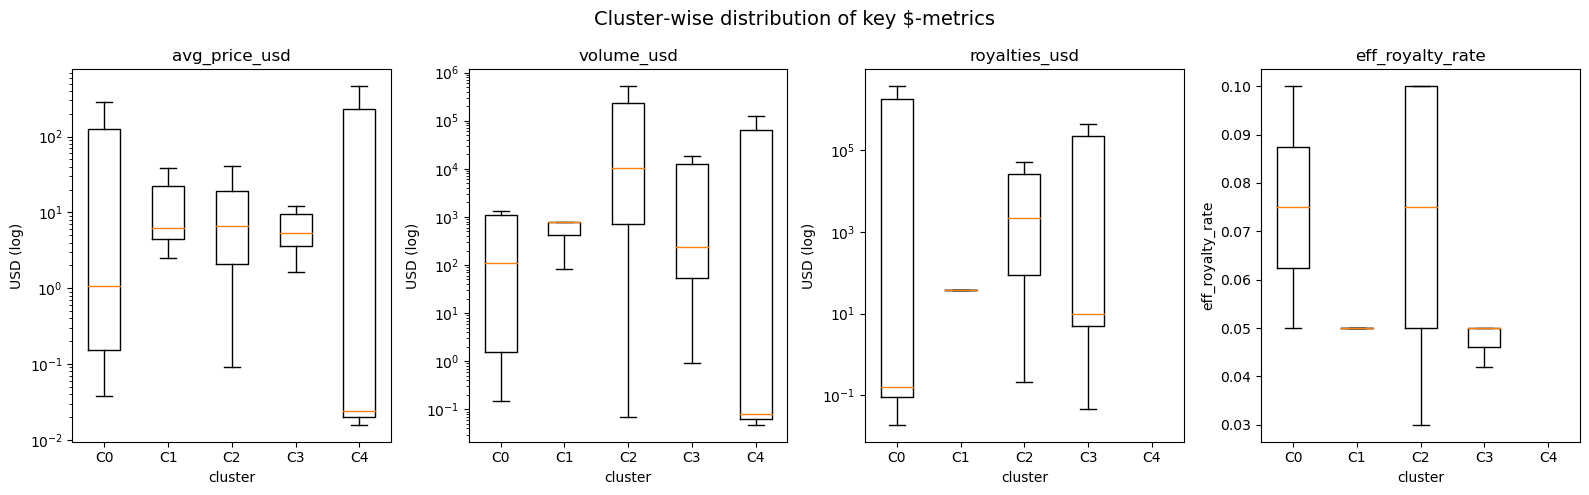

Kruskal‑Wallis H‑tests across clusters
avg_price_usd    : H =   2.92   p = 0.5705
volume_usd       : H =  10.59   p = 0.0316
royalties_usd    : H =   1.08   p = 0.5835
eff_royalty_rate : H =   4.82   p = 0.0898

↳ Summary per cluster written to cluster_financial_summary.csv


In [36]:
# ─────────────────────────────────────────────────────────────────────────────
# Cluster–level performance exploration
# ─────────────────────────────────────────────────────────────────────────────
import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import kruskal

DB = "cluster_performance.db"

# 1) -------------------------------------------------------------------------
with sqlite3.connect(DB) as con:
    df = pd.read_sql_query(
        """
        SELECT slug_name, cluster_label,
               avg_price_usd, volume_usd, royalties_usd, royalty_fee
        FROM   sampled_collections
        """, con
    )

# keep only rows where at least one $‑metric exists
df = df[df[["avg_price_usd", "volume_usd", "royalties_usd"]].notna().any(axis=1)].copy()

df = df.dropna(subset=["cluster_label"])
clusters = sorted(df["cluster_label"].unique())
labels   = [f"C{int(c)}" for c in clusters]

# 2) -------------------------------------------------------------------------
# supply / size proxies
df["approx_sales"]      = df["volume_usd"] / df["avg_price_usd"]
df["eff_royalty_rate"]  = df.apply(
    lambda r: r["royalties_usd"] / r["volume_usd"]
              if pd.notnull(r["royalties_usd"]) and r["volume_usd"] else np.nan,
    axis=1
)

# 3) -------------------------------------------------------------------------
metrics = ["avg_price_usd", "volume_usd", "royalties_usd", "eff_royalty_rate"]
log_axes = {"avg_price_usd", "volume_usd", "royalties_usd"}   # log‑scale these

plt.style.use("default")
fig, axs = plt.subplots(1, len(metrics), figsize=(4*len(metrics), 5))

for ax, m in zip(axs, metrics):
    # prepare data‑per‑cluster
    clusters = sorted(df["cluster_label"].unique())
    data     = [df.loc[df["cluster_label"] == c, m].dropna() for c in clusters]

    ax.boxplot(data, labels=[f"C{int(c)}" for c in clusters], showfliers=False)
    ax.set_title(m)
    if m in log_axes:
        ax.set_yscale("log")
    ax.set_xlabel("cluster")
    ax.set_ylabel("USD (log)" if m in log_axes else m)

fig.suptitle("Cluster‑wise distribution of key $‑metrics", fontsize=14)
plt.tight_layout()
plt.show()

# 4) -------------------------------------------------------------------------
print("Kruskal‑Wallis H‑tests across clusters")
for m in metrics:
    groups = [df.loc[df["cluster_label"] == c, m].dropna() for c in clusters]
    # need ≥2 non‑empty groups
    valid = [g for g in groups if len(g) > 1]
    if len(valid) < 2:
        print(f"{m:17}: not enough data")
        continue
    H, p = kruskal(*valid)
    print(f"{m:17}: H = {H:6.2f}   p = {p:.4f}")

"""
Interpreting p:
  p < .05  → distributions differ significantly (exploratory evidence)
  higher p → no clear evidence of difference given the sample size
"""

# 5) (optional) save aggregated table for appendix ---------------------------
agg = (
    df.groupby("cluster_label")
      .agg(n_collections = ("slug_name", "count"),
           med_price_usd = ("avg_price_usd", "median"),
           med_volume_usd = ("volume_usd", "median"),
           med_royalties_usd = ("royalties_usd", "median"),
           med_roy_rate = ("eff_royalty_rate", "median"))
      .reset_index()
)
agg.to_csv("cluster_financial_summary.csv", index=False)
print("\n↳ Summary per cluster written to cluster_financial_summary.csv")